# Cap Training Data

This notebook is responsible for constructing corpus with respect to *Entity Label Cap*.

In [1]:
!pip install seaborn

## Import

In [2]:
import os
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")

## Utils function

### Sequence model

This is the class used to represent a sequence in the NER corpus. 

credits: https://github.com/masakhane-io/masakhane-ner

In [3]:
class InputExample(object):
    """A single training/test example for token classification."""

    def __init__(self, guid, words, labels):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            words: list. The words of the sequence.
            labels: (Optional) list. The labels for each word of the sequence. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.words = words
        self.labels = labels

## Load dataset function

This function loads the dataset from text files into an InputExample object.

credits: https://github.com/masakhane-io/masakhane-ner

In [4]:
def read_examples_from_file(data_dir, mode):
    file_path = os.path.join(data_dir, "{}.txt".format(mode))
    guid_index = 1
    examples = []
    with open(file_path, encoding="utf-8") as f:
        words = []
        labels = []
        for line in f:
            line = line.strip()
            if len(line) < 2  or line == "\n":
                # print(line, words)
                if words:
                    examples.append(InputExample(guid="{}-{}".format(mode, guid_index), words=words, labels=labels))
                    guid_index += 1
                    words = []
                    labels = []
            else:
                splits = line.split(" ")
                words.append(splits[0])
                if len(splits) > 1:
                    labels.append(splits[-1].replace("\n", ""))
                else:
                    # Examples could have no label for mode = "test"
                    labels.append("O")
        if words:
            examples.append(InputExample(guid="{}-{}".format(mode, guid_index), words=words, labels=labels))
    return examples

## Get labels position

This function return entity label position form a string of labels. 

Example: 
Input: ['O', 'B-PER', 'I-PER', 'O', 'B-ORG', 'O', 'O', 'O', 'B-ORG'] 
Data: [(1, 2), (4, 4), (8, 8)]

In [5]:
def get_labels_position(labels):
    label =  []
    in_word = False
    start_idx = -1

    for i in range(len(labels)):
        
        if labels[i].startswith('B-'):
            if in_word is True:
                label.append((start_idx, i-1))
                
            in_word = True
            start_idx = i
            
        elif labels[i] == 'O' and in_word == True:
            label.append((start_idx, i - 1))
            in_word = False
            
    return label

def get_capped_labels(labels, labels_pos, cap):
    import random
    random.seed(42)

    for (x, y) in random.sample(labels_pos, max(len(labels_pos) - cap, 0)):
        labels[x:y + 1] = ['O' for _ in range(len(labels[x:y + 1]))]
       
    return labels

## Get capped examples

This function cut off surplus of labels for an established *Enitty Label Cap* value. If we see that the label of a particular sequence is greater that the the cap established, we cut off the surplus.

In [6]:
def get_capped_examples(X, cap):
    n_examples = []
    for ex in X:
        labels_pos = get_labels_position(ex.labels.copy())
        ex.labels = get_capped_labels(ex.labels.copy(), labels_pos, cap)
        n_examples.append(ex)
            
    return n_examples

## Write modified examples

This function use the previously defined functions to modify the dataset with respect to the *cap* established.

In [7]:
def write_modified_examples(data_dir, mode, X, cap):
        
    folder_path = os.path.join(data_dir, "cap-{}".format(cap))
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        
    file_path =  os.path.join(folder_path, "{}.txt".format(mode))
    
    n_examples = get_capped_examples(X, cap)
    
    with open(file_path, "w+", encoding="utf-8") as f:
        for ex in n_examples:
            for i in range(len(ex.labels)):
                f.write(f"{ex.words[i]} {ex.labels[i]}\n")
            f.write("\n")
            
    f.close()

## Modifying the corpus

In [9]:
from shutil import copyfile

langs = ["swa", "kin", "pcm"]

for lang in langs:
    for cap in range(1, 11):
        examples = read_examples_from_file(f'../data/{lang}', 'train')
        write_modified_examples(f'../data/{lang}', 'train', examples, cap=cap)
        copyfile(f'../data/{lang}/dev.txt', f'../data/{lang}/cap-{cap}/dev.txt')
        copyfile(f'../data/{lang}/test.txt', f'../data/{lang}/cap-{cap}/test.txt')

## Modified Corpus Analytics

In this section, we get the statistics of the different language corpus. We particularly check the distributions of entity labels over the corpus.

In [8]:
def get_label_density_statistics(X):
    
    n_labels = []
    for ex in X:
        n_labels.append(len(get_labels_position(ex.labels.copy())))
        
    return np.mean(n_labels), np.std(n_labels), max(set(n_labels), key=n_labels.count), *np.unique(n_labels, return_counts=True), n_labels

In [10]:
data = []
# mean, std, mode, x, y, n_labels = 


for lang in langs:
    examples = read_examples_from_file(f'../data/{lang}/cap-10', 'train')
    data.append(get_label_density_statistics(examples))
    
data = np.array(data, dtype=object)

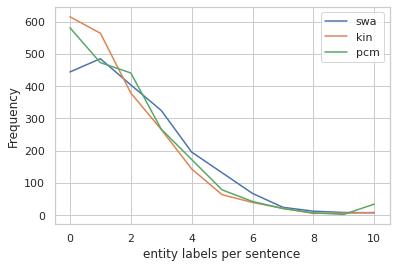

In [11]:
import matplotlib.pyplot as plt


for i in range(len(langs)):
    plt.plot(data[i, 3], data[i, 4], label=langs[i])

plt.legend()
plt.ylabel('Frequency')
plt.xlabel('entity labels per sentence')
plt.savefig('../images/evlution.png')

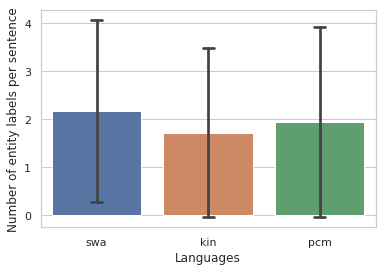

In [12]:
import itertools

sns.barplot(x=list(itertools.chain([langs[0]]*len(data[0, -1]), [langs[1]]*len(data[1, -1]), [langs[2]]*len(data[2, -1]))), 
            y=list(itertools.chain(data[0, -1], data[1, -1], data[2, -1])),
            capsize=.1,
           estimator=np.mean,
           ci="sd")

plt.ylabel('Number of entity labels per sentence')
plt.xlabel('Languages')
plt.savefig('../images/dist_plot.png')